## NPS and Wait Time Pulled from 2024

    RAW AWT  AWT NORM     Group
0  0.016667 -0.435126  Promoter
1  0.066667 -0.421642  Promoter
2  9.050000  2.000909  Promoter
3  3.816667  0.589627  Promoter
4  0.033333 -0.430631  Promoter


/tmp/ipykernel_8482/3340989095.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='RAW AWT', data=data, palette="Set2")


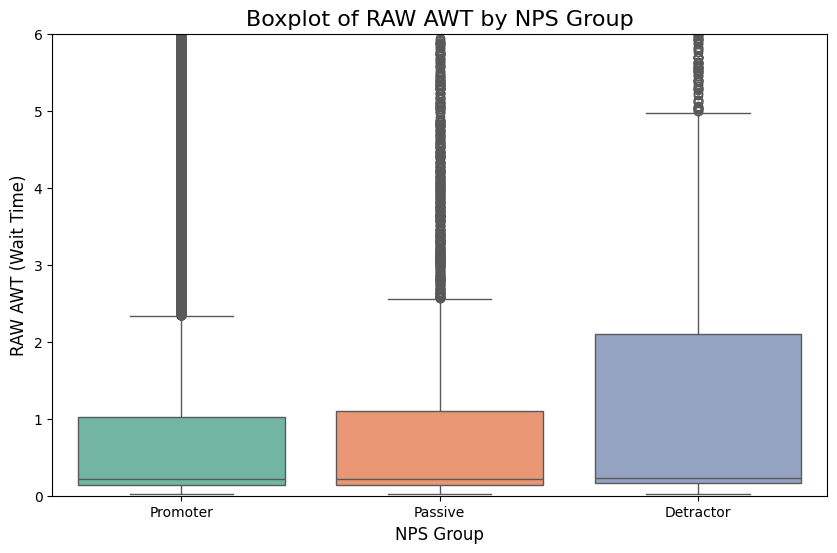

<Figure size 640x480 with 0 Axes>

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("AWT vs. NPS.csv")

# Display the first few rows to confirm data structure
print(data.head())

# Create the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Group', y='RAW AWT', data=data, palette="Set2")

# Customize the plot
plt.title('Boxplot of RAW AWT by NPS Group', fontsize=16)
plt.xlabel('NPS Group', fontsize=12)
plt.ylabel('RAW AWT (Wait Time)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Limit the y-axis to 10 minutes
plt.ylim(0, 6)

# Add annotations for the major values
for i, artist in enumerate(ax.artists):
    group_name = data['Group'].unique()[i]
    group_data = data[data['Group'] == group_name]['RAW AWT']
    
    # Calculate key boxplot statistics
    q1 = group_data.quantile(0.25)  # First quartile (25th percentile)
    median = group_data.median()    # Median (50th percentile)
    q3 = group_data.quantile(0.75)  # Third quartile (75th percentile)
    iqr = q3 - q1                   # Interquartile range
    lower_whisker = max(group_data.min(), q1 - 1.5 * iqr)
    upper_whisker = min(group_data.max(), q3 + 1.5 * iqr)
    
    # Annotate the key statistics
    ax.text(i, lower_whisker - 0.3, f'{lower_whisker:.1f}', ha='center', fontsize=8, color='blue')
    ax.text(i, q1 - 0.3, f'{q1:.1f}', ha='center', fontsize=8, color='green')
    ax.text(i, median + 0.3, f'{median:.1f}', ha='center', fontsize=8, color='red', fontweight='bold')
    ax.text(i, q3 + 0.3, f'{q3:.1f}', ha='center', fontsize=8, color='green')
    ax.text(i, upper_whisker + 0.3, f'{upper_whisker:.1f}', ha='center', fontsize=8, color='blue')

# Show the plot
plt.show()

# Save the plot (Optional)
plt.savefig("boxplot_raw_awt_nps_labeled.png", dpi=300, bbox_inches='tight')
